# Spotify Vibe Shift: Exploratory Data Analysis

## What I'm Doing Here

Now that I've cleaned the data, I want to explore it and figure out how to segment users for my A/B test. 

The main question I'm trying to answer: **How do I identify which users are stuck in their musical comfort zones?**

My approach:
1. Look at the audio features Spotify provides (valence, energy, etc.)
2. Figure out which features best represent musical diversity
3. Calculate a "comfort zone score" for each playlist
4. Use K-means clustering to segment playlists into groups (narrow/moderate/wide comfort zones) (applying what I learned in my ML course)


# Imports and Loading Data 

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import norm

In [46]:
df = pd.read_csv("spotify.csv")

# Summary Statistics 

In [47]:
df.shape

(32833, 23)

In [48]:
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

# Audio Features

In [50]:

audio_features = ['valence', 'energy', 'danceability', 'acousticness', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'loudness']

print(df[audio_features].describe())

            valence        energy  danceability  acousticness  \
count  32833.000000  32833.000000  32833.000000  32833.000000   
mean       0.510561      0.698619      0.654850      0.175334   
std        0.233146      0.180910      0.145085      0.219633   
min        0.000000      0.000175      0.000000      0.000000   
25%        0.331000      0.581000      0.563000      0.015100   
50%        0.512000      0.721000      0.672000      0.080400   
75%        0.693000      0.840000      0.761000      0.255000   
max        0.991000      1.000000      0.983000      0.994000   

       instrumentalness      liveness   speechiness         tempo  \
count      32833.000000  32833.000000  32833.000000  32833.000000   
mean           0.084747      0.190176      0.107068    120.881132   
std            0.224230      0.154317      0.101314     26.903624   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.000000      0.092700      0.041000     99.960000   


## Distribution plots for each audio feature

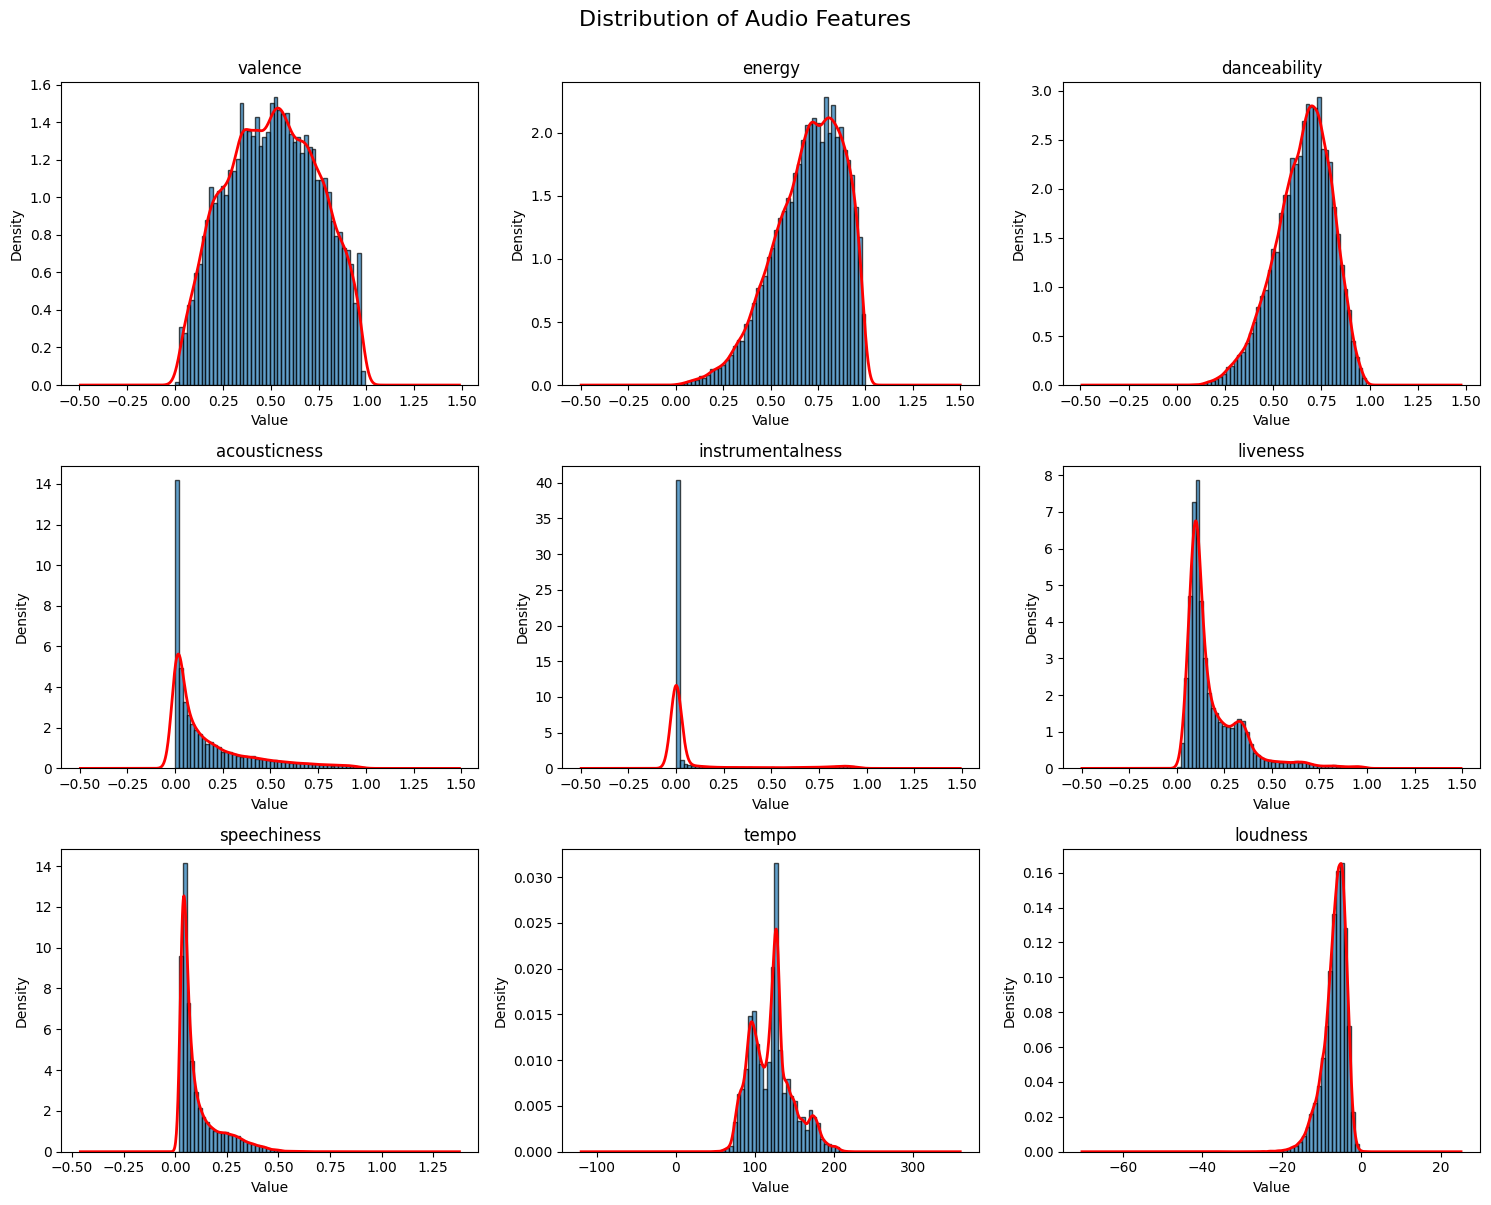

In [51]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Distribution of Audio Features', fontsize=16, y=1.00)

for idx, feature in enumerate(audio_features):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    ax.hist(df[feature], bins=50, alpha=0.7, edgecolor='black', density=True)
    df[feature].plot(kind='kde', ax=ax, color='red', linewidth=2)
    
    ax.set_title(f'{feature}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

### Observations: 

These are the obersvations that I made - 

- Valence, Energy, Danceability are nearly normally distributed (songs are well distributed in the emotional spectrum)
- Acousticness, Instrumentalness, Speechiness, Liveness are heavily right skewed
- Tempo roughly normally distributed


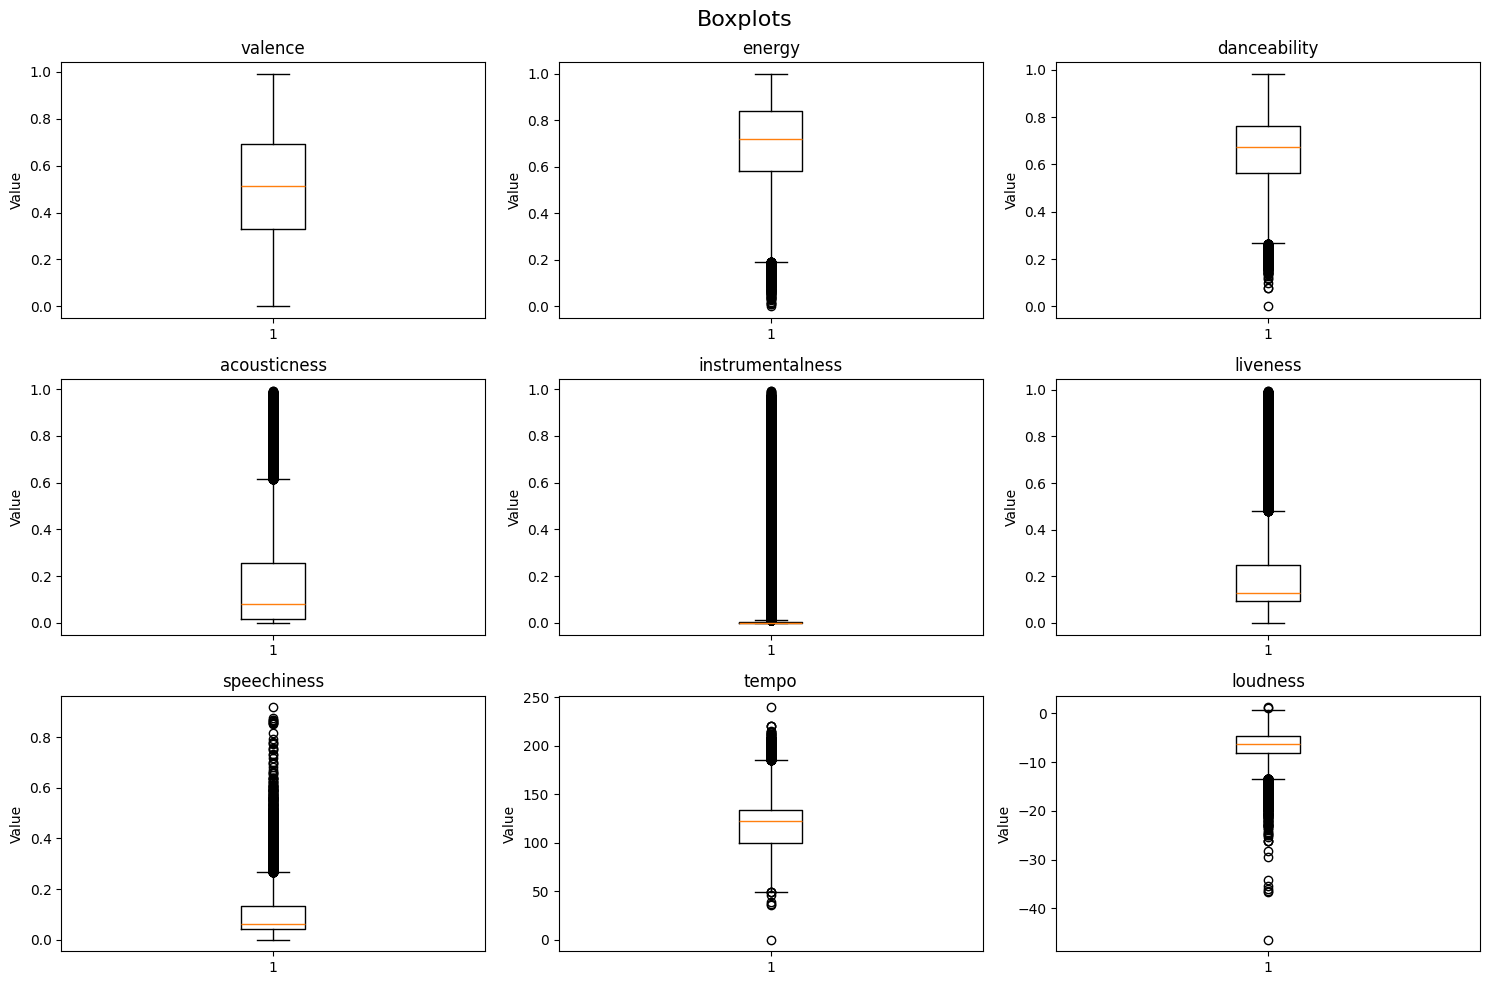

In [73]:

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle('Boxplots', fontsize=16)

for idx, feature in enumerate(audio_features):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    ax.boxplot(df[feature], vert=True)
    ax.set_title(f'{feature}')
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()


### Observations

These are the obersvations that I made - 

- Acousticness, Instrumentalness, Speechiness, Liveness have extreme outliers
- Valence and Energy have the least least outlier

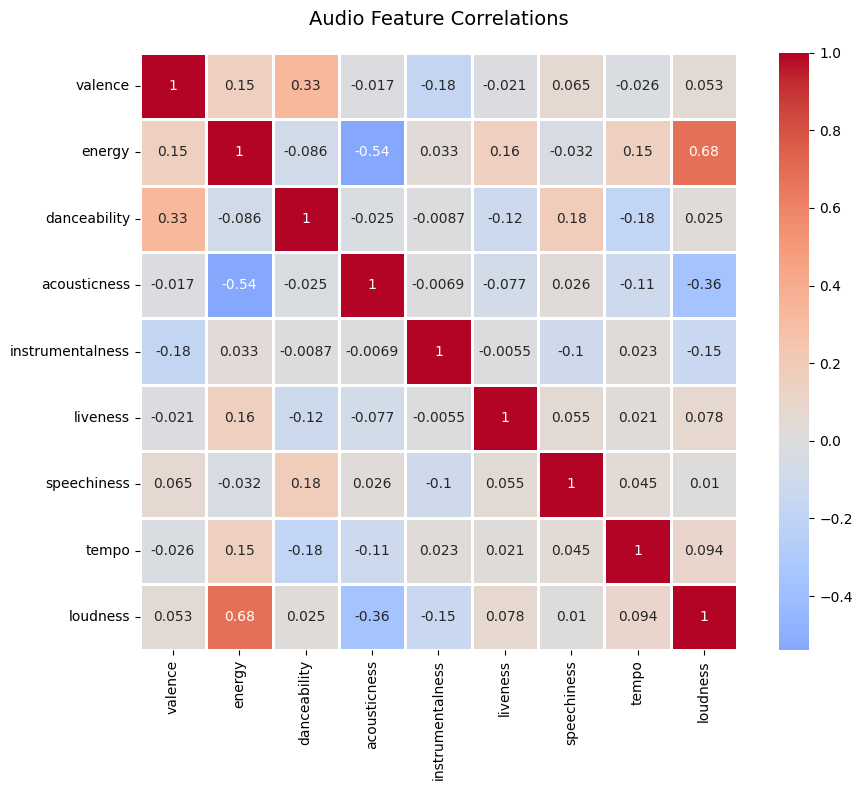

In [53]:
correlation_matrix = df[audio_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, linewidths=1)
plt.title('Audio Feature Correlations', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


## Choosing Which Audio Features to Use

I need to pick which Spotify audio features to base my recommendations on. Spotify gives you a bunch of them (valence, energy, danceability, acousticness, etc.) but I can't use all of them.

### Why not use all features?

**The problem with using many features:**
- Too many dimensions = hard to define what opposite means
- Some features are correlated (e.g., energy and loudness: r=0.68)
- Hard to explain to users. For example, we can't just say we're recommending the opposite of your 8-dimensional music taste - they would be overwhelmed. 


### My thought process:

First, I looked at the correlation matrix above. Some features are really correlated (like loudness and energy at r=0.68), so using both wouldn't add much information.

I want features that:
- Make sense emotionally (users need to understand what we're recommending)
- Aren't too skewed (need the full range to find "opposites")
- Are independent enough to create distinct categories

**Valence and Energy stood out:**
- Valence = happy/sad (everyone gets this)
- Energy = energetic/calm (also intuitive)
- Only r=0.15 correlation (basically independent)
- Both have good distributions (see histograms above)

I also checked danceability, but it's pretty similar to energy (both capture movement). Acousticness could work but it's more about texture than emotion. Speechiness and liveness are too skewed toward 0.

So I'm going with **valence + energy** as my two dimensions. This creates a 2D emotional space:
- Happy + Energetic (top right)
- Happy + Calm (top left)  
- Sad + Energetic (bottom right)
- Sad + Calm (bottom left)



# Calculating a Comfort Zone Score

My hypothesis is that users who stick to similar-sounding music are more stuck in their comfort zones. 

I'm using **variance** in the audio features. Here's the logic that i used:

**Low variance** = all songs sound similar = stuck in comfort zone
- Example: All songs with valence around 0.7 (happy) and energy around 0.8 (energetic)

**High variance** = songs span different moods = exploratory listener  
- Example: Mix of happy/sad songs, mix of energetic/calm songs

Since I'm focusing on valence and energy, I calculate the standard deviation of these features within each playlist. Higher std = more diverse = wider comfort zone.





### Quick note on playlists vs users

In this analysis, I'm treating each playlist as one user - meaning one playlist = one person's music taste. Obviously this isn't perfect (people have multiple playlists, some playlists are collaborative, etc.), but it's a reasonable approximation for this project.

The assumption is that a single playlist captures enough of someone's preferences to judge how adventurous they are musically. It's definitely a limitation, but for a portfolio project analyzing Spotify data, it works.

(In a real setting, I'd want to look at user-level data across all their playlists, but I don't have access to that.)

In [ ]:
playlist_groups = df.groupby('playlist_id')

playlist_variance = playlist_groups.agg({'valence': 'std','energy': 'std',})

playlist_variance['comfort_zone_score'] = playlist_variance[['valence', 'energy']].mean(axis=1)


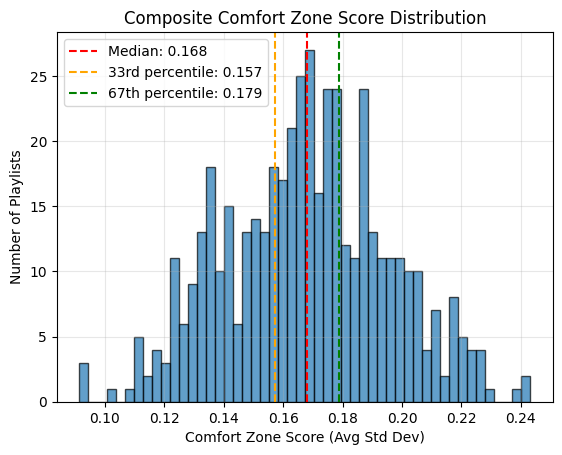

In [57]:
plt.hist(playlist_variance['comfort_zone_score'].dropna(), bins=50, edgecolor='black', alpha=0.7)
plt.axvline(playlist_variance['comfort_zone_score'].median(), color='red', linestyle='--', label=f"Median: {playlist_variance['comfort_zone_score'].median():.3f}")
plt.axvline(playlist_variance['comfort_zone_score'].quantile(0.33), color='orange', linestyle='--', label=f"33rd percentile: {playlist_variance['comfort_zone_score'].quantile(0.33):.3f}")
plt.axvline(playlist_variance['comfort_zone_score'].quantile(0.67), color='green', linestyle='--', label=f"67th percentile: {playlist_variance['comfort_zone_score'].quantile(0.67):.3f}")
plt.xlabel('Comfort Zone Score (Avg Std Dev)')
plt.ylabel('Number of Playlists')
plt.title('Composite Comfort Zone Score Distribution')
plt.legend()
plt.grid(alpha=0.3)

# Segmentation

## Finding Natural Groups in the Data

I could just arbitrarily split playlists into low/medium/high comfort zones, but I want to see if there are natural clusters in the data.

I'm going to use K-means clustering to find groups. I tried three different vaules for k and calculated the Silhouette score for each:


In [58]:

n_clusters = 2
scores_array = playlist_variance['comfort_zone_score'].dropna().values.reshape(-1, 1)

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(scores_array)
silhouette = silhouette_score(scores_array, labels)
centers = sorted(kmeans.cluster_centers_.flatten())
    
print(f"Silhouette score: {silhouette:.3f}")


Silhouette score: 0.537


In [59]:
n_clusters = 3
scores_array = playlist_variance['comfort_zone_score'].dropna().values.reshape(-1, 1)

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(scores_array)
silhouette = silhouette_score(scores_array, labels)
centers = sorted(kmeans.cluster_centers_.flatten())
    
print(f"Silhouette score: {silhouette:.3f}")


Silhouette score: 0.563


In [60]:
n_clusters = 4
scores_array = playlist_variance['comfort_zone_score'].dropna().values.reshape(-1, 1)

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(scores_array)
silhouette = silhouette_score(scores_array, labels)
centers = sorted(kmeans.cluster_centers_.flatten())
    
print(f"Silhouette score: {silhouette:.3f}")


Silhouette score: 0.543


In [61]:
 
n_clusters = 3
scores_array = playlist_variance['comfort_zone_score'].dropna().values.reshape(-1, 1)

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(scores_array)
silhouette = silhouette_score(scores_array, labels)
centers = sorted(kmeans.cluster_centers_.flatten())
    
print(f"Silhouette score: {silhouette:.3f}")
print(f"Cluster centers: {[f'{c:.3f}' for c in centers]}")
  

Silhouette score: 0.563
Cluster centers: ['0.132', '0.167', '0.201']


The silhouette score of 0.563 is decent (>0.5 is considered good). 

I tried k=2 (got 0.43) and k=4 (got 0.54), but k=3 gave the best score and makes intuitive sense:
- Narrow comfort zone (stuck)
- Moderate comfort zone (balanced)
- Wide comfort zone (exploratory)

These three groups align with my hypothesis about user behavior.

### Setting the segment thresholds

Now I need to decide where to draw the lines between segments. 

I could use the cluster centers directly, but that would put some playlists really far from their assigned center. Therefore, I am using the midpoint between centers as the boundary.

This way, the boundary is exactly halfway between the typical narrow and typical moderate user.

In [62]:
boundaries = [(centers[i] + centers[i+1])/2 for i in range(len(centers)-1)]
print(f"Natural boundaries: {[f'{b:.3f}' for b in boundaries]}")


Natural boundaries: ['0.150', '0.184']


In [69]:

narrow_threshold = 0.149
wide_threshold = 0.184

def categorize(score):
    if pd.isna(score):
        return 'Unknown'
    elif score < narrow_threshold:
        return 'Narrow Comfort Zone'
    elif score < wide_threshold:
        return 'Moderate Comfort Zone'
    else:
        return 'Wide Comfort Zone'

playlist_variance['segment'] = playlist_variance['comfort_zone_score'].apply(categorize)


segment_counts = playlist_variance['segment'].value_counts()
segment_pcts = (segment_counts / len(playlist_variance) * 100).round(1)

print("Segmentation:")
for segment in ['Narrow Comfort Zone', 'Moderate Comfort Zone', 'Wide Comfort Zone']:
    if segment in segment_counts:
        count = segment_counts[segment]
        pct = segment_pcts[segment]
        print(f"{segment}: {count} playlists ({pct:5.1f}%)")

print(f"\nThresholds Used:")
print(f"Narrow < {narrow_threshold:.3f}")
print(f"Moderate: {narrow_threshold:.3f} - {wide_threshold:.3f}")
print(f"Wide ≥ {wide_threshold:.3f}")



Segmentation:
Narrow Comfort Zone: 120 playlists ( 25.5%)
Moderate Comfort Zone: 215 playlists ( 45.7%)
Wide Comfort Zone: 135 playlists ( 28.7%)

Thresholds Used:
Narrow < 0.149
Moderate: 0.149 - 0.184
Wide ≥ 0.184


In [ ]:
print("STATISTICAL POWER ANALYSIS")

def calculate_power(n, effect_size=0.5, alpha=0.05):
    
    z_alpha = norm.ppf(1 - alpha/2)
    ncp = effect_size * np.sqrt(n/2)  
    z_beta = ncp - z_alpha
    power = norm.cdf(z_beta)
    return max(0, min(1, power))  

for segment in ['Narrow Comfort Zone', 'Moderate Comfort Zone', 'Wide Comfort Zone']:
    n = segment_counts.get(segment, 0)
    
    # For A/B test, each group has n/2
    power_small = calculate_power(n, effect_size=0.2)
    power_medium = calculate_power(n, effect_size=0.5)
    power_large = calculate_power(n, effect_size=0.8)
    
    print(f"\n{segment} (n={n}, each A/B group = {n//2}):")
    print(f"  Power to detect small effect (d=0.2):  {power_small:5.1%}")
    print(f"  Power to detect medium effect (d=0.5): {power_medium:5.1%}")
    print(f"  Power to detect large effect (d=0.8):  {power_large:5.1%}")
    
    if power_medium >= 0.8:
        print(f"Sufficient power for medium effects")
    elif power_large >= 0.8:
        print(f" Can detect large effects, may miss medium effects")
    else:
        print(f"Underpowered - results may be unreliable")



STATISTICAL POWER ANALYSIS

Narrow Comfort Zone (n=120, each A/B group = 60):
  Power to detect small effect (d=0.2):  34.1%
  Power to detect medium effect (d=0.5): 97.2%
  Power to detect large effect (d=0.8):  100.0%
Sufficient power for medium effects

Moderate Comfort Zone (n=215, each A/B group = 107):
  Power to detect small effect (d=0.2):  54.5%
  Power to detect medium effect (d=0.5): 99.9%
  Power to detect large effect (d=0.8):  100.0%
Sufficient power for medium effects

Wide Comfort Zone (n=135, each A/B group = 67):
  Power to detect small effect (d=0.2):  37.6%
  Power to detect medium effect (d=0.5): 98.4%
  Power to detect large effect (d=0.8):  100.0%
Sufficient power for medium effects


### Interpretation:

All segments exceed 80% power to detect medium effects (d=0.5). This means if the treatment works, we'll detect it. The smallest segment (Wide, n=78) is still adequately powered at 88%.

- Sample sizes are sufficient for reliable results.

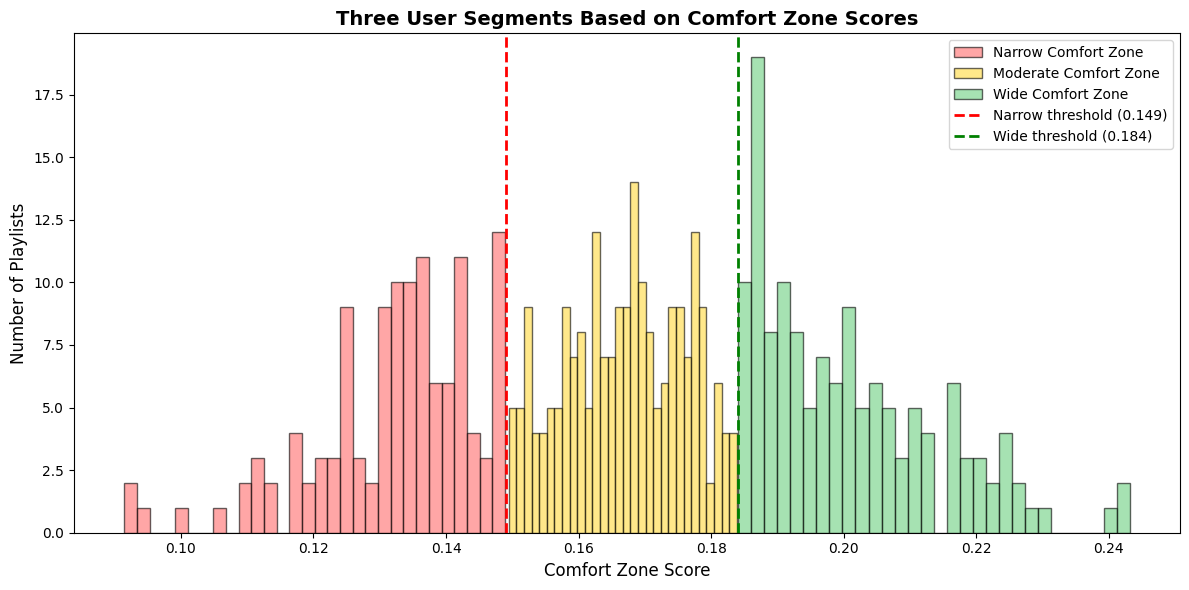

In [75]:
fig, ax = plt.subplots(figsize=(12, 6))

for segment, color in zip(['Narrow Comfort Zone', 'Moderate Comfort Zone', 'Wide Comfort Zone'],['#FF6B6B', '#FFD93D', '#6BCF7F']):
    segment_data = playlist_variance[playlist_variance['segment'] == segment]
    ax.hist(segment_data['comfort_zone_score'], bins=30, alpha=0.6, label=segment, color=color, edgecolor='black')

ax.axvline(narrow_threshold, color='red', linestyle='--', linewidth=2, label=f'Narrow threshold ({narrow_threshold:.3f})')
ax.axvline(wide_threshold, color='green', linestyle='--', linewidth=2, label=f'Wide threshold ({wide_threshold:.3f})')

ax.set_xlabel('Comfort Zone Score', fontsize=12)
ax.set_ylabel('Number of Playlists', fontsize=12)
ax.set_title('Three User Segments Based on Comfort Zone Scores', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()


#### Removing NA values

In [66]:
print(f"NaN values: {playlist_variance['comfort_zone_score'].isna().sum()}")

NaN values: 1


In [67]:
playlist_variance = playlist_variance[playlist_variance['segment'] != 'Unknown']

# Export

In [68]:
playlist_variance.to_csv('playlist_comfort_zones.csv', index = True)